In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import keras
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import integrated_gradients as ig
import my_utils
from metaplot import Metaplot, one_hot_encode

In [2]:
#import human data
df = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/seelig/Samples/GSM3130443_designed_library.csv')
df = df.iloc[:280000]

df = df[(df['library'] == 'human_utrs') | (df['library'] == 'snv')]
df = df.sort_values('total', ascending=False).reset_index(drop=True)
df = df.iloc[:25000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:5000]
e_train = df.iloc[20000:]


def one_hot_encode(df, col='utr', seq_len=50):
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(df),seq_len,4])
    
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))



/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_22882/3821936504.py:2: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/seelig/Samples/GSM3130443_designed_library.csv')
/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_22882/3821936504.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))


In [3]:
#define model architecture and train on 5utrs (no uAUG) with modified functions from Sample et al.

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []



def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2



model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=5,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

#model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/data/models/mrl_model_human.hdf5')

e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print('r-squared = ', r)

#model.save('/Users/frederickkorbel/Documents/projects/paper/data/models/mrl_model_human.hdf5')


2022-03-09 14:15:55.920730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 14:15:56.121992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
40/40 [==============================] - 7s 157ms/step - loss: 0.9933
Epoch 2/5
40/40 [==============================] - 7s 167ms/step - loss: 0.8723
Epoch 3/5
40/40 [==============================] - 9s 238ms/step - loss: 0.8164
Epoch 4/5
40/40 [==============================] - 10s 243ms/step - loss: 0.7044
Epoch 5/5
40/40 [==============================] - 15s 374ms/step - loss: 0.3896
r-squared =  0.7076386307540019


/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_22882/434409436.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


<font color=lightblue size=20>Load Predictions and perform Attributions</font>

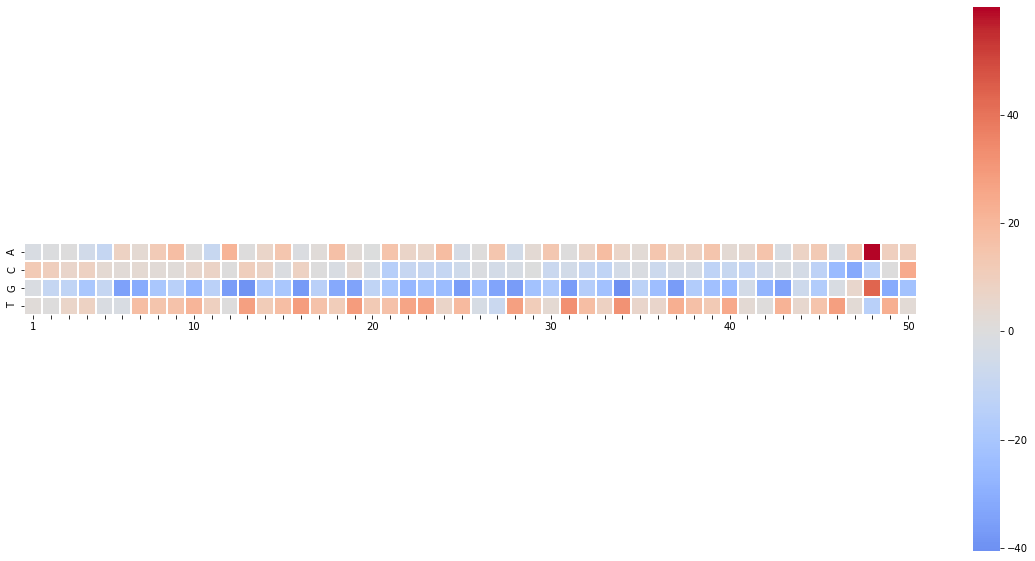

In [4]:
random_data = e_test.sample(n=2000, random_state = 1)
random_data_seq = one_hot_encode(random_data, seq_len=50)
random_data_ig = ig.integrated_gradients(model, random_data_seq)
Metaplot(random_data_ig, colorbar = True)

500


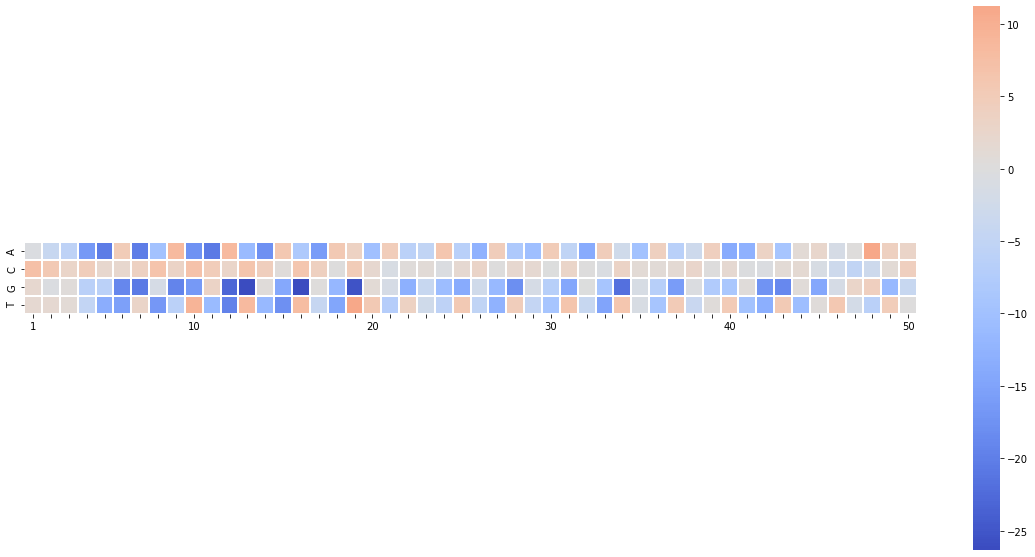

In [5]:
lowest_ten = e_test[e_test['pred'] <= e_test['pred'].quantile(0.1)]
print(len(lowest_ten))
lowest_ten_seq = one_hot_encode(lowest_ten, seq_len=50)
lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
Metaplot(lowest_ten_ig, colorbar = True)

500


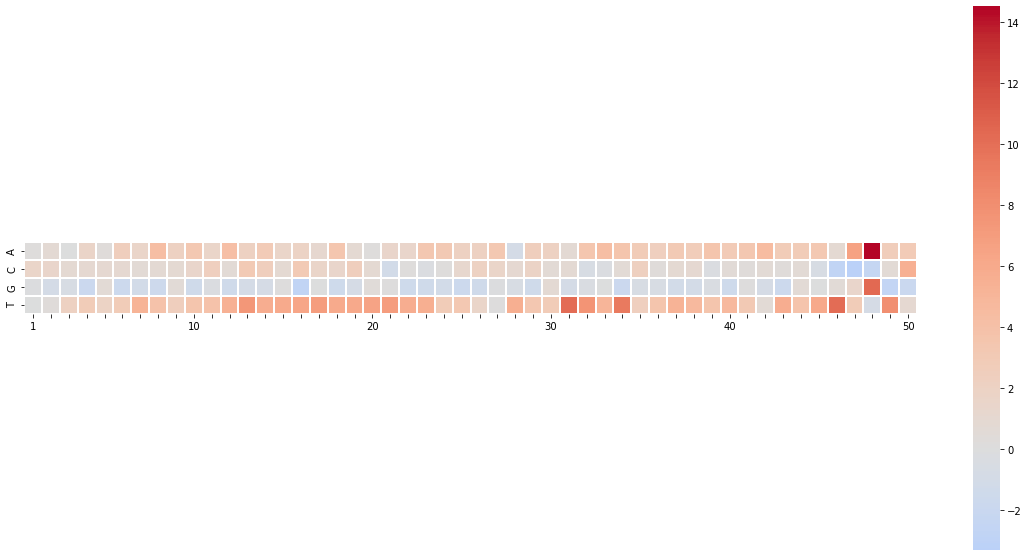

In [6]:
highest_ten = e_test[e_test['pred'] >= e_test['pred'].quantile(0.9)]
print(len(highest_ten))
highest_ten_seq = one_hot_encode(highest_ten, seq_len=50)
highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
Metaplot(highest_ten_ig, colorbar = True)

In [7]:
highest_ten

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,id,info1,info2,info3,info4,library,mother,designed,match_score,pred
11,18,CCGTTTGTCCTAGCTTTTCTCTTCTGTCAACCCCACACGCCTTTGG...,664,624,367,590,544,631,1037,1507,...,NC_000004.12:g.73404283T>C,rs375806262,chr4:73404247-73404330,snv,normal,snv,CCGTTTGTCCTAGCTTTTCTCTTCTGTCAACCCCACACGCCTTTGG...,True,0.0,6.533458
14,22,CCCGCGAGCTTTCTTCTCGCCTTCGCATCTCCTCCTCGCGCTTCTT...,750,753,497,574,691,738,1300,1645,...,NC_000014.9:g.91947238C>A_v1,rs184393277,chr14:91947226-91947309,snv,variant,snv,CCCGCGAGCTTTCTTCTCGCCTTCGCATCTCCTCCTCGCGCGTCTT...,True,0.0,6.590831
15,24,GTTTCTTCTTCCTTCCCCCTTCCCCCAACTTCCCTCCACCCCTTCC...,635,913,542,886,1199,1439,2025,1207,...,NC_000011.10:g.103109542C>T,rs547159267,chr11:103109494-103109577,snv,normal,snv,GTTTCTTCTTCCTTCCCCCTTCCCCCAACTTCCCTCCACCCCTTCC...,True,0.0,6.698727
17,27,GCTTATAAAGCTTGCTATTTCTGGCATTTTTTCCTCTTTCTCTGCT...,1102,789,376,484,511,508,903,1121,...,11659,ENSG00000124191,ENST00000358131,-,-,human_utrs,GCTTATAAAGCTTGCTATTTCTGGCATTTTTTCCTCTTTCTCTGCT...,True,0.0,6.665760
20,31,CCGTGCACACGTCTCCCGCTCTCCCCGATATTCTCTAAGCCGCTTT...,628,694,396,542,542,624,1115,1297,...,33462,ENSG00000152767,ENST00000595437,-,-,human_utrs,CCGTGCACACGTCTCCCGCTCTCCCCGATATTCTCTAAGCCGCTTT...,True,0.0,6.547036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,6985,CCGCCCTTCGTGCTTGAAAAAAAATCCCGCGAAGCCTTCTCCGAAA...,142,136,83,94,90,84,173,217,...,24707,ENSG00000182518,ENST00000489298,-,-,human_utrs,CCGCCCTTCGTGCTTGAAAAAAAATCCCGCGAAGCCTTCTCCGAAA...,True,0.0,6.588682
4955,2479,CCGCCTGTAGGAAAACTGAAGACTTTAATAACAAACTCTCCAAGGT...,177,123,68,119,112,131,171,212,...,NaN,NaN,NaN,NaN,NaN,human_utrs,CTGCCTGTAGGAAAACTGAAGACTTTAATAACAAACTCTCCAAGGT...,False,98.0,6.690300
4960,7028,CCAGAAGATACCTTAAGGTTCCCTGGTTGTGAAAATACATGAGATA...,129,93,51,101,200,191,416,210,...,29105,ENSG00000011465,ENST00000549513,-,-,human_utrs,CCAGAAGATACCTTAAGGTTCCCTGGTTGTGAAAATACATGAGATA...,True,0.0,6.559182
4973,2493,CATTTGAAATTAGTGTTTCAGCTGAACCATCCGTTCATCTTCAAGC...,127,94,47,92,88,96,168,249,...,NaN,NaN,NaN,NaN,NaN,human_utrs,AATTTGAAATTAGTGTTTCAGCTGAACCATCCGTTCATCTTCAAGC...,False,98.0,6.724653
